In [38]:
import pandas as pd
import torch
import ltn
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

### 1. Initial data analysis

In [25]:
file_path = 'Stud_E-mobility_data_staticLimit.csv'
data = pd.read_csv(file_path)
data_info = data.info()
data_head = data.head()
data_description = data.describe()
(data_info, data_head, data_description)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59442 entries, 0 to 59441
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   _time                       59442 non-null  object 
 1   GARAGE_EXTERNAL_POWER       59442 non-null  float64
 2   DEMAND_LIMIT                59442 non-null  float64
 3   DEMAND_LIMIT_INDICATOR      59442 non-null  float64
 4   BATTERY_SOC                 59442 non-null  float64
 5   BATTERY_DISCHARGE_POWER     59442 non-null  float64
 6   BATTERY_CHARGED_ENERGY      59442 non-null  float64
 7   BATTERY_DISCHARGED_ENERGY   59442 non-null  float64
 8   PV_POWER                    59442 non-null  float64
 9   PV_ENERGY                   59442 non-null  float64
 10  WALLBOX_ALPHA_ENERGY        59442 non-null  float64
 11  WALLBOX_ALPHA_POWER         59442 non-null  float64
 12  WALLBOX_1_ENERGY            59442 non-null  float64
 13  WALLBOX_1_POWER             594

(None,
                        _time  GARAGE_EXTERNAL_POWER  DEMAND_LIMIT  \
 0  2023-10-05 00:01:00+00:00               1.244171          50.0   
 1  2023-10-05 00:02:00+00:00               1.244171          50.0   
 2  2023-10-05 00:03:00+00:00               1.244171          50.0   
 3  2023-10-05 00:04:00+00:00               1.244171          50.0   
 4  2023-10-05 00:05:00+00:00               1.244171          50.0   
 
    DEMAND_LIMIT_INDICATOR  BATTERY_SOC  BATTERY_DISCHARGE_POWER  \
 0                     1.0         40.5                   -0.338   
 1                     1.0         40.5                   -0.372   
 2                     1.0         40.5                   -0.393   
 3                     1.0         40.5                   -0.339   
 4                     1.0         40.5                   -0.371   
 
    BATTERY_CHARGED_ENERGY  BATTERY_DISCHARGED_ENERGY  PV_POWER  PV_ENERGY  \
 0                     0.0                        0.0  0.008693        0.0   
 1   

In [26]:
# Rule 1: SOC > 80%
mask_soc_above_80 = data['BATTERY_SOC'] > 80

# Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
mask_40_to_80_high_power = (data['BATTERY_SOC'] > 40) & (data['BATTERY_SOC'] < 80) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT'])

# Rule 3a: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
mask_below_40_high_power = (data['BATTERY_SOC'] < 40) & (data['GARAGE_EXTERNAL_POWER'] > data['DEMAND_LIMIT'])

# Rule 3b: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
mask_below_40_low_power = (data['BATTERY_SOC'] < 40) & (data['GARAGE_EXTERNAL_POWER'] < data['DEMAND_LIMIT'])

# Rule 4: SOC < 15%
mask_below_15 = data['BATTERY_SOC'] < 15


data_soc_above_80 = data[mask_soc_above_80]
data_40_to_80_high_power = data[mask_40_to_80_high_power]
data_below_40_high_power = data[mask_below_40_high_power]
data_below_40_low_power = data[mask_below_40_low_power]
data_below_15 = data[mask_below_15]e
count_rules = {
    "SOC > 80%": len(data_soc_above_80),
    "40% < SOC < 80% and High Power": len(data_40_to_80_high_power),
    "SOC < 40% and High Power": len(data_below_40_high_power),
    "SOC < 40% and Low Power": len(data_below_40_low_power),
    "SOC < 15%": len(data_below_15)
}

count_rules


{'SOC > 80%': 0,
 '40% < SOC < 80% and High Power': 579,
 'SOC < 40% and High Power': 3524,
 'SOC < 40% and Low Power': 6925,
 'SOC < 15%': 202}

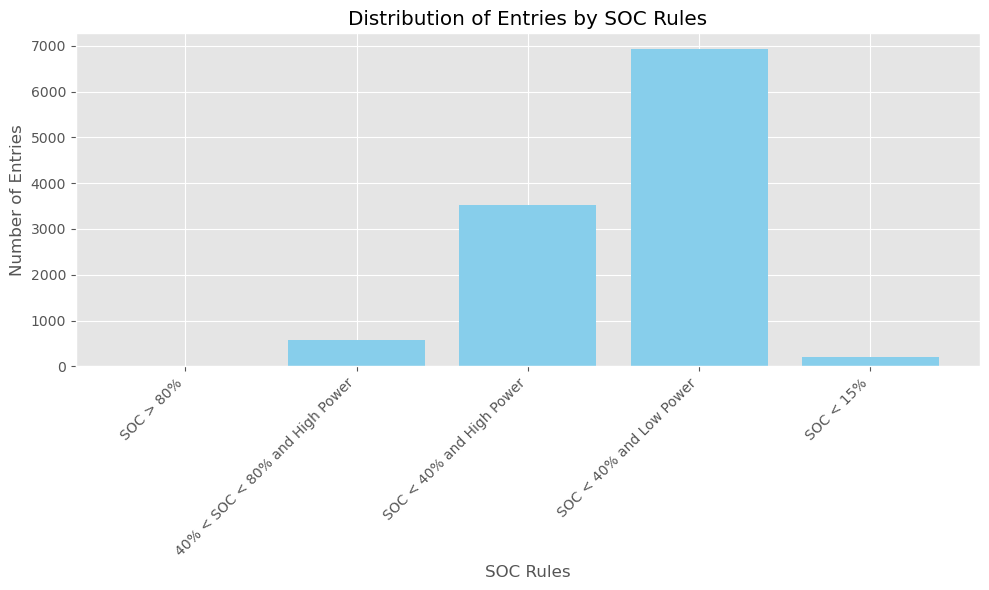

In [29]:
counts_df = pd.DataFrame(list(count_rules.items()), columns=['Rule', 'Count'])
# Plotting
plt.figure(figsize=(10, 6))
plt.bar(counts_df['Rule'], counts_df['Count'], color='skyblue')
plt.xlabel('SOC Rules')
plt.ylabel('Number of Entries')
plt.title('Distribution of Entries by SOC Rules')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels

plt.show()


In [30]:
total_entries_covered = sum(count_rules.values())
total_entries_covered

11230

In [31]:
len(data)

59442

In [32]:
print("Total Entries Covered by Rules: ", total_entries_covered *100/(len(data)) )

Total Entries Covered by Rules:  18.892365667373237


### 2. Create new datset  which corresponds to the following ground rules 

In [33]:
# Combine all the filtered datasets into one that satisfies any of the rules
combined_data = pd.concat([
    data_soc_above_80,
    data_40_to_80_high_power,
    data_below_40_high_power,
    data_below_40_low_power,
    data_below_15
])
# Drop duplicate entries if any entry matches multiple rules
combined_data = combined_data.drop_duplicates()
# Save the combined dataset to a new CSV file
output_file_path = 'Filtered_Emobility_Data.csv'
combined_data.to_csv(output_file_path, index=False)




In [34]:
data_modified = pd.read_csv(output_file_path)

In [48]:
# Define the rules based on SOC
def evaluate_rules(df):
    # Rule 1: SOC > 80%
    rule1 = (df['BATTERY_SOC'] > 80)

    # Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
    rule2 = (df['BATTERY_SOC'] > 40) & (df['BATTERY_SOC'] < 80) & (df['GARAGE_EXTERNAL_POWER'] > df['DEMAND_LIMIT'])

    # Rule 3: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
    rule3 = (df['BATTERY_SOC'] < 40) & (df['GARAGE_EXTERNAL_POWER'] > df['DEMAND_LIMIT'])

    # Rule 4: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
    rule4 = (df['BATTERY_SOC'] < 40) & (df['GARAGE_EXTERNAL_POWER'] < df['DEMAND_LIMIT'])

    # Rule 5: SOC < 15% (Battery discharging stopped)
    rule5 = (df['BATTERY_SOC'] < 15)

    # Calculate the number of times each rule is satisfied
    rule1_sat = rule1.mean()
    rule2_sat = rule2.mean()
    rule3_sat = rule3.mean()
    rule4_sat = rule4.mean()
    rule5_sat = rule5.mean()

    return {
        "Rule 1 (SOC > 80%)": rule1_sat,
        "Rule 2 (40% < SOC < 80%)": rule2_sat,
        "Rule 3 (SOC < 40% and POWER > LIMIT)": rule3_sat,
        "Rule 4 (SOC < 40% and POWER < LIMIT)": rule4_sat,
        "Rule 5 (SOC < 15%)": rule5_sat
    }

# Evaluate rules
rule_satisfaction = evaluate_rules(data_modified)
rule_satisfaction


{'Rule 1 (SOC > 80%)': 0.0,
 'Rule 2 (40% < SOC < 80%)': 0.05250272034820457,
 'Rule 3 (SOC < 40% and POWER > LIMIT)': 0.31955023576351105,
 'Rule 4 (SOC < 40% and POWER < LIMIT)': 0.6279470438882844,
 'Rule 5 (SOC < 15%)': 0.018317011244105914}

In [51]:
# Convert necessary columns to tensors
soc_tensor = torch.tensor(data_modified['BATTERY_SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data_modified['GARAGE_EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data_modified['DEMAND_LIMIT'].values, dtype=torch.float32)

# Display the tensors (showing the first few elements for brevity)
soc_tensor[:10], external_power_tensor[:10], demand_limit_tensor[:10]

(tensor([40.5000, 40.5000, 40.5000, 40.5000, 40.5000, 40.5000, 40.5000, 40.5000,
         40.5000, 40.5000]),
 tensor([50.2441, 50.2441, 50.3399, 54.8379, 51.9668, 50.2441, 53.6895, 50.4356,
         50.2441, 57.9004]),
 tensor([50., 50., 50., 50., 50., 50., 50., 50., 50., 50.]))

In [53]:
# Define the model for SOC-Based Actions
class SOCModel(torch.nn.Module):
    def __init__(self):
        super(SOCModel, self).__init__()
        self.elu = torch.nn.ELU()
        self.softmax = torch.nn.Softmax(dim=1)
        self.dense1 = torch.nn.Linear(3, 10)  # Input is SOC, external power, demand limit
        self.dense2 = torch.nn.Linear(10, 5)
        self.dense3 = torch.nn.Linear(5, 2)   # Output two probabilities: 0 for no action, 1 for action taken

    def forward(self, x):
        """x: tensor of [soc, external_power, demand_limit]"""
        x = self.elu(self.dense1(x))
        x = self.elu(self.dense2(x))
        return self.softmax(self.dense3(x))

# Create the predicate based on the model
class ChargingPredicate(torch.nn.Module):
    def __init__(self, model):
        super(ChargingPredicate, self).__init__()
        self.model = model
    
    def forward(self, soc, external_power, demand_limit):
        inputs = torch.stack([soc, external_power, demand_limit], dim=1)
        return self.model(inputs)

# Instantiate model and predicate
soc_model = SOCModel()
charging_predicate = ChargingPredicate(soc_model)

# Checking the model by passing the first few elements
charging_output = charging_predicate(soc_tensor[:5], external_power_tensor[:5], demand_limit_tensor[:5])
charging_output


tensor([[0.9889, 0.0111],
        [0.9889, 0.0111],
        [0.9890, 0.0110],
        [0.9925, 0.0075],
        [0.9904, 0.0096]], grad_fn=<SoftmaxBackward0>)

In [54]:


class BatteryManagementLTN(torch.nn.Module):
    def __init__(self, charging_predicate):
        super().__init__()
        self.charging_predicate = charging_predicate
    def forward(self, soc, external_power, demand_limit):
        # Getting predictions from the predicate model
        actions = self.charging_predicate(soc, external_power, demand_limit)
        # Logical Rules
        # Extracting action probability assuming index 1 corresponds to action taken
        action_taken = actions[:, 1]
        # Rule 1: SOC > 80%
        rule1 = (soc > 80) * action_taken
        # Rule 2: 40% < SOC < 80% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
        rule2 = ((soc > 40) & (soc < 80) & (external_power > demand_limit)) * action_taken
        # Rule 3: SOC < 40% and GARAGE_EXTERNAL_POWER > DEMAND_LIMIT
        rule3 = ((soc < 40) & (external_power > demand_limit)) * action_taken
        # Rule 4: SOC < 40% and GARAGE_EXTERNAL_POWER < DEMAND_LIMIT
        rule4 = ((soc < 40) & (external_power < demand_limit)) * action_taken
        # Rule 5: SOC < 15%
        rule5 = (soc < 15) * (1 - action_taken) 
        sat_agg = torch.mean(torch.stack([rule1, rule2, rule3, rule4, rule5], dim=0))
        return sat_agg
# Instantiate and apply the model
battery_management_ltn = BatteryManagementLTN(charging_predicate)
satisfaction_level = battery_management_ltn(soc_tensor, external_power_tensor, demand_limit_tensor)
print(f"Satisfaction Level: {satisfaction_level.item()}")


Satisfaction Level: 0.005361109506338835


In [56]:
import ltn.fuzzy_ops as fuzzy_ops

In [59]:
soc_values = data_modified['BATTERY_SOC'].values.astype(np.float32)
external_power_values = data_modified['GARAGE_EXTERNAL_POWER'].values.astype(np.float32)
demand_limit_values = data_modified['DEMAND_LIMIT'].values.astype(np.float32)
# Convert to PyTorch tensors
soc_tensor = torch.tensor(soc_values)
external_power_tensor = torch.tensor(external_power_values)
demand_limit_tensor = torch.tensor(demand_limit_values)

In [60]:
# Redefine the LTN variables with the new tensors
soc = ltn.Variable("soc", soc_tensor)
external_power = ltn.Variable("external_power", external_power_tensor)
demand_limit = ltn.Variable("demand_limit", demand_limit_tensor)


In [67]:
# Redefining the model and predicate
class BatteryManagementModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Linear(3, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 4),  
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
model = BatteryManagementModel()
predicate = ltn.Predicate(model)
def conditions(soc, external_power, demand_limit):
    inputs = torch.stack([soc, external_power, demand_limit], dim=1)
    return predicate(inputs)
forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
sat_agg = ltn.fuzzy_ops.SatAgg()
soc_tensor = torch.tensor(data_modified['SOC'].values, dtype=torch.float32)
external_power_tensor = torch.tensor(data_modified['EXTERNAL_POWER'].values, dtype=torch.float32)
demand_limit_tensor = torch.tensor(data_modified['DEMAND_LIMIT'].values, dtype=torch.float32)
# Define conditions function to apply model directly on tensor inputs
def conditions(soc, external_power, demand_limit):
    inputs = torch.stack([soc, external_power, demand_limit], dim=1)
    return model(inputs)  # Directly using the model here

# Define Logical Rules using tensor operations
def rule1():
    # SOC > 80%: Complete charging coverage by the battery
    condition = soc_tensor > 80
    return forall(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 0])

def rule2():
    # 40% < SOC < 80% and external power > demand limit
    condition = (soc_tensor > 40) & (soc_tensor < 80) & (external_power_tensor > demand_limit_tensor)
    return forall(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 1])

def rule3a():
    # SOC < 40% and external power > demand limit
    condition = (soc_tensor < 40) & (external_power_tensor > demand_limit_tensor)
    return forall(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 2])

def rule3b():
    # SOC < 40% and external power < demand limit: Battery charged from the grid
    condition = (soc_tensor < 40) & (external_power_tensor < demand_limit_tensor)
    return forall(condition.float() * conditions(soc_tensor, external_power_tensor, demand_limit_tensor)[:, 3])

def rule4():
    # SOC < 15%: Discharging stopped due to battery health
    condition = soc_tensor < 15
    return forall(condition.float() * (1 - conditions(soc_tensor, external_power_tensor, demand_limit_tensor).sum(dim=1)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
satisfaction_levels = []
for epoch in range(2000):
    optimizer.zero_grad()
    loss = 1 - sat_agg([rule1(), rule2(), rule3a(), rule3b(), rule4()])
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        satisfaction_level = 1 - loss.item()
        satisfaction_levels.append(satisfaction_level)
        print(f"Epoch {epoch}: Satisfaction Level {satisfaction_level}")

# Report the last recorded satisfaction level
print(f"Final Satisfaction Level: {satisfaction_levels[-1]}")


KeyError: 'SOC'